In [2]:
import sys
sys.path.append('..')

In [3]:
import tsflex
print(tsflex.__version__)

0.3.0


## Get the data

In [4]:
from tsflex.utils.data import load_empatica_data

df_tmp, df_acc, df_gsr, df_ibi = load_empatica_data(["tmp", "acc", "gsr", "ibi"])

In [5]:
from pandas.tseries.frequencies import to_offset

data = [df_tmp, df_acc, df_gsr, df_ibi]
for df in data:
    print("Time-series:", df.columns.values)
    print(df.shape)
    try:
        print("Sampling rate:", 1 / pd.to_timedelta(to_offset(pd.infer_freq(df.index))).total_seconds(), "Hz")
    except:
        print("Irregular sampling rate")
    print()

Time-series: ['TMP']
(30200, 1)
Irregular sampling rate

Time-series: ['ACC_x' 'ACC_y' 'ACC_z']
(241620, 3)
Irregular sampling rate

Time-series: ['EDA']
(30204, 1)
Irregular sampling rate

Time-series: ['IBI']
(1230, 1)
Irregular sampling rate



## Look at the data

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=len(data), cols=1, shared_xaxes=True, 
    subplot_titles=[df.columns.values[0].split('_')[0] for df in data],
    vertical_spacing=0.1,
)

for plot_idx, df in enumerate(data, 1):
    # Select first minute of data
    sub_df = df.first('1min')
    for col in df.columns:
        fig.add_trace(
            go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
            row=plot_idx, col=1
        )

fig.update_layout(height=len(data)*200)

fig.show(renderer="iframe")

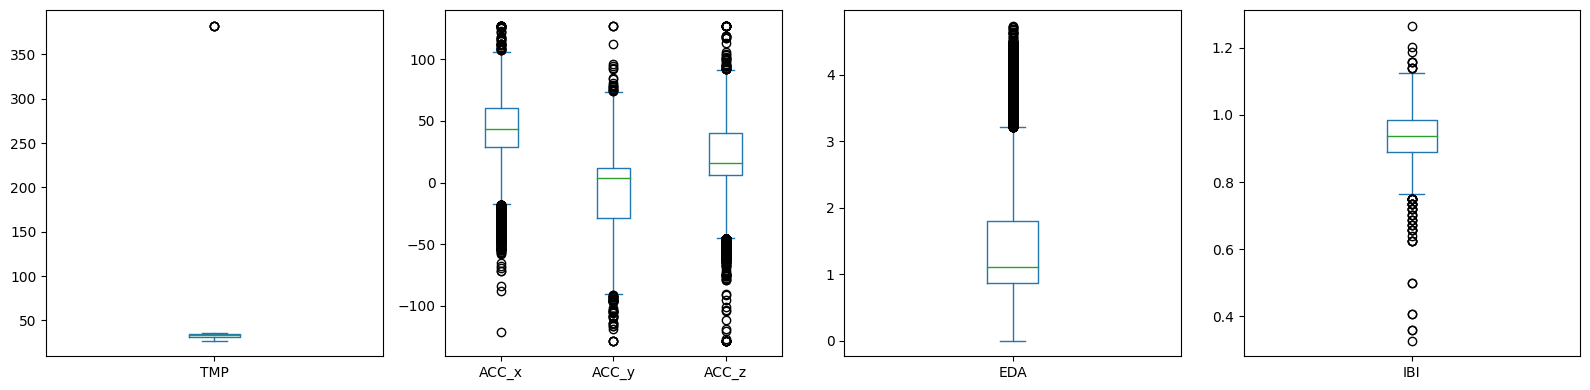

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for plot_idx, df in enumerate(data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

These visualizations indicate that some preprocessing might be necessary for the signals (some sort of clipping)

# tsflex processing

This is roughly identical to the processing of [this paper notebook](https://github.com/predict-idlab/tsflex/blob/main/examples/tsflex_paper.ipynb)

In [9]:
import pandas as pd; import numpy as np; from scipy.signal import savgol_filter
from tsflex.processing import SeriesProcessor, SeriesPipeline

# Create the processing functions
def clip_data(sig: pd.Series, min_val=None, max_val=None) -> np.ndarray:
    return np.clip(sig,  a_min=min_val, a_max=max_val)

def smv(*sigs) -> pd.Series:
    sig_prefixes = set(sig.name.split('_')[0] for sig in sigs)
    result = np.sqrt(np.sum([np.square(sig) for sig in sigs], axis=0))
    return pd.Series(result, index=sigs[0].index, name='|'.join(sig_prefixes)+'_'+'SMV')

# Create the series processors (with their keyword arguments)
tmp_clippper = SeriesProcessor(clip_data, series_names="TMP", max_val=35)
acc_savgol = SeriesProcessor(
    savgol_filter, ["ACC_x", "ACC_y", "ACC_z"], window_length=33, polyorder=2
)
acc_smv = SeriesProcessor(smv, ("ACC_x", "ACC_y", "ACC_z"))

# Create the series pipeline & process the data
series_pipe = SeriesPipeline([tmp_clippper, acc_savgol, acc_smv])
series_pipe

[
	clip_data {'max_val': 35} :  ('TMP',)
	savgol_filter {'window_length': 33, 'polyorder': 2} :  ('ACC_x',) ('ACC_y',) ('ACC_z',)
	smv {} :  ('ACC_x', 'ACC_y', 'ACC_z')
]

In [10]:
out_data = series_pipe.process(data, drop_keys=["ACC_x", "ACC_y", "ACC_z"])

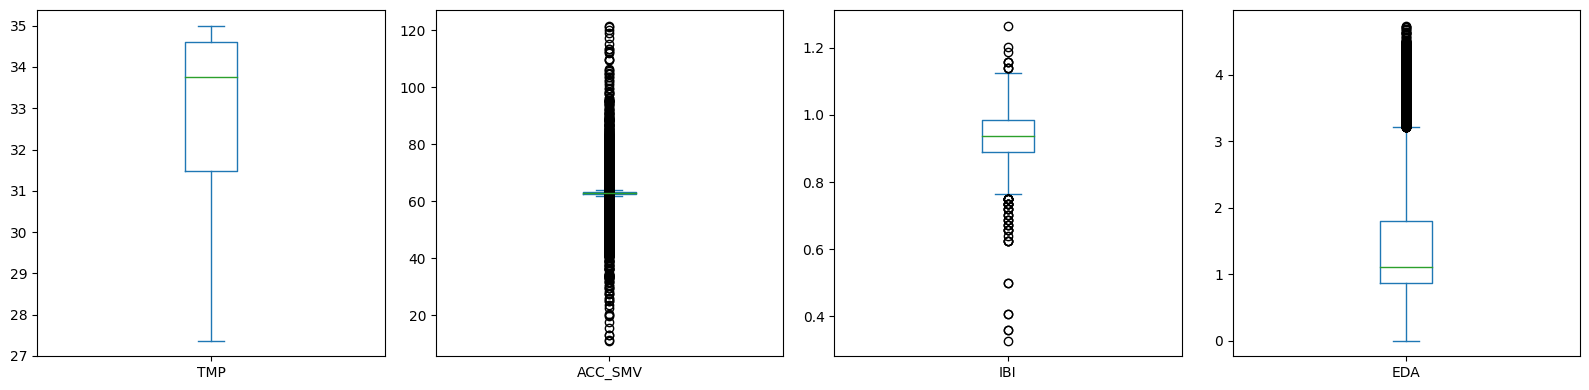

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for plot_idx, df in enumerate(out_data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

# tsflex feature extraction with [antropy](https://github.com/raphaelvallat/antropy) integration

In [13]:
# !pip install antropy

> Useful links;  
> [More detailed documentation of the antropy features](https://raphaelvallat.com/antropy/build/html/api.html)  

**<i>basic</i> `antropy` features**:  
Most `antropy` features are simple functions that return 1 value, and have no mandatory keyword arguments. As a result, they can be used directly in tsflex. However, if you want to change the default value of one of the keywords arguments, you can wrap the function in a `FuncWrapper` object. 

**<i>advanced</i> `antropy` features**:  
`antropy` features that should always be wrapped with a `FuncWrapper` are;
* `spectral_entropy` (because it requires the `fs` keyword argument)
* `hjorth_params` (because it returns 2 values)

In [14]:
from tsflex.features import FeatureCollection, MultipleFeatureDescriptors

## Using basic antropy features

In [15]:
import antropy as ant

In [16]:
from tsflex.features import MultipleFeatureDescriptors, FeatureCollection

to_wrap_features = ["spectral_entropy", "hjorth_params"]

# All fractal features are "basic"
fractal_features = [getattr(ant, f) for f in ant.fractal.all]
# All entropy features are "basic" except for the ones that are in to_wrap_features
entropy_features = [getattr(ant, f) for f in ant.entropy.all if f not in to_wrap_features]

basic_funcs = fractal_features #+ entropy_features

basic_feats = MultipleFeatureDescriptors(
        functions=basic_funcs,
        series_names=["ACC_SMV", "EDA", "TMP"],
        windows=["5min", "2.5min"],
        strides="2min",
    )
feature_collection = FeatureCollection(basic_feats)
feature_collection

ACC_SMV: (
	win: 5m    : [
		FeatureDescriptor - func: FuncWrapper(petrosian_fd, ['petrosian_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(katz_fd, ['katz_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(higuchi_fd, ['higuchi_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(detrended_fluctuation, ['detrended_fluctuation'], {})    stride: ['2m'],
	]
	win: 2m30s : [
		FeatureDescriptor - func: FuncWrapper(petrosian_fd, ['petrosian_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(katz_fd, ['katz_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(higuchi_fd, ['higuchi_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(detrended_fluctuation, ['detrended_fluctuation'], {})    stride: ['2m'],
	]
)
EDA: (
	win: 5m    : [
		FeatureDescriptor - func: FuncWrapper(petrosian_fd, ['petrosian_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(katz_fd, ['katz_fd'], {

In [17]:
features_df = feature_collection.calculate(out_data, return_df=True, n_jobs=1)
features_df

Traceback (most recent call last):
  File "/users/jonvdrdo/jeroen/git/temp/tsflex/examples/../tsflex/features/feature_collection.py", line 632, in calculate
    calculated_feature_list = [self._executor(idx) for idx in idxs]
  File "/users/jonvdrdo/jeroen/git/temp/tsflex/examples/../tsflex/features/feature_collection.py", line 632, in <listcomp>
    calculated_feature_list = [self._executor(idx) for idx in idxs]
  File "/users/jonvdrdo/jeroen/git/temp/tsflex/examples/../tsflex/features/feature_collection.py", line 266, in _executor
    return stroll.apply_func(function)
  File "/users/jonvdrdo/jeroen/git/temp/tsflex/examples/../tsflex/features/segmenter/strided_rolling.py", line 450, in apply_func
    list(
  File "/users/jonvdrdo/jeroen/git/temp/tsflex/examples/../tsflex/features/function_wrapper.py", line 114, in __call__
    return self.func(*series, **self.kwargs)
  File "/users/jonvdrdo/jeroen/venv/lib/python3.8/site-packages/antropy/fractal.py", line 446, in detrended_fluctuation

RuntimeError: Feature Extraction halted due to error while extracting one (or multiple) feature(s)! See stack trace above.

### Plot the EDA features

In [22]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    subplot_titles=['Raw EDA data', 'EDA features'],
    vertical_spacing=0.1,
)

fig.add_trace(
    go.Scattergl(x=df_gsr.index[::4*5], y=df_gsr['EDA'].values[::4*5], name='EDA', mode='markers'),
    row=1, col=1
)

ibi_feats = [c for c in features_df.columns if 'EDA_' in c and 'w=2m30s_' in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
        row=2, col=1
    )

fig.update_layout(height=2*350)

fig.show(renderer='iframe')

## Using advanced features

In [23]:
# Import some "advanced" tsfel features
from tsfel.feature_extraction.features import (
    # Some temporal features
    calc_centroid, auc, entropy, neighbourhood_peaks,
    # Some statistical features
    hist, ecdf, ecdf_percentile_count,
    # Some spectral features
    spectral_distance, fundamental_frequency, max_power_spectrum, 
    spectral_centroid, spectral_decrease, spectral_kurtosis,
    spectral_spread, human_range_energy, mfcc, fft_mean_coeff,
    wavelet_abs_mean, wavelet_std, wavelet_energy
)

In [24]:
# Import all feature functions from seg-learn

from tsflex.features import FeatureCollection, MultipleFeatureDescriptors, FuncWrapper

advanced_feats = MultipleFeatureDescriptors(
    functions=[
        # Temporal
        FuncWrapper(calc_centroid, fs=4), FuncWrapper(auc, fs=4),
        FuncWrapper(entropy, prob="kde", output_names="entropy_kde"),
        FuncWrapper(entropy, prob="gauss", output_names="entropy_gauss"),
        FuncWrapper(neighbourhood_peaks, n=5, output_names="neighbourhood_peaks_n=5"),
        # Statistical
        FuncWrapper(hist, nbins=4, output_names=[f"hist{i}" for i in range(1,5)]),
        FuncWrapper(ecdf, output_names=[f"ecdf{i}" for i in range(1,11)]),
        FuncWrapper(ecdf_percentile_count, output_names=["ecdf_0.2", "ecdf_0.8"]),
        # Spectral
        FuncWrapper(spectral_distance, fs=4), FuncWrapper(fundamental_frequency, fs=4),
        FuncWrapper(max_power_spectrum, fs=4), FuncWrapper(spectral_centroid, fs=4),
        FuncWrapper(spectral_decrease, fs=4), FuncWrapper(spectral_kurtosis, fs=4),
        FuncWrapper(spectral_spread, fs=4), FuncWrapper(human_range_energy, fs=4),
        FuncWrapper(mfcc, fs=4, num_ceps=6, output_names=[f"mfcc{i}" for i in range(1,7)]),
        FuncWrapper(fft_mean_coeff, fs=4, nfreq=8, output_names=[f"fft_mean_coeff_{i}" for i in range(8)]),
        FuncWrapper(wavelet_abs_mean, output_names=[f"wavelet_abs_mean_{i}" for i in range(1,10)]),
        FuncWrapper(wavelet_std, output_names=[f"wavelet_std_{i}" for i in range(1,10)]),
        FuncWrapper(wavelet_energy, widths=np.arange(1, 5), output_names=[f"wavelet_energy_{i}" for i in range(1,5)]),
    ],
    series_names=["EDA", "TMP"],
    windows=["5min", "2.5min"],
    strides=["2.5min"],
)
feature_collection = FeatureCollection(advanced_feats)
feature_collection

EDA: (
	win: 5m    , stride: 2m30s: [
		FeatureDescriptor - func: FuncWrapper(calc_centroid, ['calc_centroid'], {'fs': 4}),
		FeatureDescriptor - func: FuncWrapper(auc, ['auc'], {'fs': 4}),
		FeatureDescriptor - func: FuncWrapper(entropy, ['entropy_kde'], {'prob': 'kde'}),
		FeatureDescriptor - func: FuncWrapper(entropy, ['entropy_gauss'], {'prob': 'gauss'}),
		FeatureDescriptor - func: FuncWrapper(neighbourhood_peaks, ['neighbourhood_peaks_n=5'], {'n': 5}),
		FeatureDescriptor - func: FuncWrapper(hist, ['hist1', 'hist2', 'hist3', 'hist4'], {'nbins': 4}),
		FeatureDescriptor - func: FuncWrapper(ecdf, ['ecdf1', 'ecdf2', 'ecdf3', 'ecdf4', 'ecdf5', 'ecdf6', 'ecdf7', 'ecdf8', 'ecdf9', 'ecdf10'], {}),
		FeatureDescriptor - func: FuncWrapper(ecdf_percentile_count, ['ecdf_0.2', 'ecdf_0.8'], {}),
		FeatureDescriptor - func: FuncWrapper(spectral_distance, ['spectral_distance'], {'fs': 4}),
		FeatureDescriptor - func: FuncWrapper(fundamental_frequency, ['fundamental_frequency'], {'fs': 4}),
		Fe

In [25]:
features_df = feature_collection.calculate(out_data, return_df=True, logging_file_path="tsfel_advanced.log")
features_df

../../tsflex_new/tsflex/tsflex/utils/logging.py:77: RuntimeWarning:

Logging file (tsfel_advanced.log) already exists. This file will be overwritten!



,EDA__auc__w=2m30s_s=2m30s,EDA__auc__w=5m_s=2m30s,EDA__calc_centroid__w=2m30s_s=2m30s,EDA__calc_centroid__w=5m_s=2m30s,EDA__ecdf10__w=2m30s_s=2m30s,EDA__ecdf10__w=5m_s=2m30s,EDA__ecdf1__w=2m30s_s=2m30s,EDA__ecdf1__w=5m_s=2m30s,EDA__ecdf2__w=2m30s_s=2m30s,EDA__ecdf2__w=5m_s=2m30s,...,TMP__wavelet_std_5__w=2m30s_s=2m30s,TMP__wavelet_std_5__w=5m_s=2m30s,TMP__wavelet_std_6__w=2m30s_s=2m30s,TMP__wavelet_std_6__w=5m_s=2m30s,TMP__wavelet_std_7__w=2m30s_s=2m30s,TMP__wavelet_std_7__w=5m_s=2m30s,TMP__wavelet_std_8__w=2m30s_s=2m30s,TMP__wavelet_std_8__w=5m_s=2m30s,TMP__wavelet_std_9__w=2m30s_s=2m30s,TMP__wavelet_std_9__w=5m_s=2m30s
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,82.461837,NaN,82.421866,NaN,0.016667,NaN,0.001667,NaN,0.003333,NaN,...,5.002295,NaN,5.841184,NaN,6.686805,NaN,7.535821,NaN,8.385133,NaN
2017-06-13 14:27:13+02:00,110.133445,192.741149,86.359785,182.039215,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,4.790044,3.638882,5.719857,4.260856,6.643068,4.889749,7.559655,5.523707,8.469133,6.160773
2017-06-13 14:29:43+02:00,125.093583,235.439719,72.334050,162.267442,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,4.937297,3.453637,5.897790,4.133228,6.850188,4.810630,7.793730,5.485410,8.728434,6.157382
2017-06-13 14:32:13+02:00,107.177666,232.470191,72.860379,135.431617,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.085715,3.597735,6.074760,4.306468,7.055956,5.012328,8.029210,5.714820,8.994736,6.413956
2017-06-13 14:34:43+02:00,120.859006,228.216110,79.609944,160.756980,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.287628,3.706909,6.315705,4.436043,7.336195,5.162769,8.348876,5.887268,9.353768,6.609739
2017-06-13 14:37:13+02:00,126.219086,247.297018,77.648459,157.409647,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.367532,3.757065,6.411893,4.497287,7.448961,5.235573,8.479117,5.972034,9.502458,6.706728
2017-06-13 14:39:43+02:00,136.526782,262.980798,77.413766,157.821477,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.378170,3.849494,6.422858,4.606399,7.458840,5.360261,8.486683,6.111283,9.506673,6.859552
2017-06-13 14:42:13+02:00,143.676892,280.456829,71.233357,152.823419,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.461435,3.892793,6.522403,4.658510,7.574513,5.420975,8.618698,6.180828,9.655310,6.938363
2017-06-13 14:44:43+02:00,119.428576,263.324091,74.143830,135.143790,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.524432,3.892039,6.597226,4.656987,7.661200,5.418797,8.716405,6.177796,9.762978,6.934192


### Plot the EDA features

In [26]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    subplot_titles=['Raw EDA data', 'EDA features'],
    vertical_spacing=0.1,
)

fig.add_trace(
    go.Scattergl(x=df_gsr.index[::4*5], y=df_gsr['EDA'].values[::4*5], name='EDA', mode='markers'),
    row=1, col=1
)

ibi_feats = [c for c in features_df.columns if 'EDA_' in c and 'w=2m30s_' in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
        row=2, col=1
    )

fig.update_layout(height=2*350)

fig.show(renderer='iframe')

### Analyze the logging results

In [27]:
from tsflex.features.logger import get_feature_logs

get_feature_logs(logging_file_path="tsfel_advanced.log")

,log_time,function,series_names,window,stride,duration
0,2021-11-20 20:32:25.123,ecdf,"(EDA,)",5m,2m30s,0 days 00:00:00.005716562
1,2021-11-20 20:32:25.125,auc,"(EDA,)",5m,2m30s,0 days 00:00:00.007787704
2,2021-11-20 20:32:25.127,calc_centroid,"(EDA,)",5m,2m30s,0 days 00:00:00.009153843
3,2021-11-20 20:32:25.129,ecdf_percentile_count,"(EDA,)",5m,2m30s,0 days 00:00:00.010959148
4,2021-11-20 20:32:25.134,calc_centroid,"(EDA,)",2m30s,2m30s,0 days 00:00:00.004325151
...,...,...,...,...,...,...
79,2021-11-20 20:32:25.517,wavelet_abs_mean,"(TMP,)",2m30s,2m30s,0 days 00:00:00.186565399
80,2021-11-20 20:32:26.316,entropy,"(EDA,)",2m30s,2m30s,0 days 00:00:01.180300236
81,2021-11-20 20:32:26.421,entropy,"(TMP,)",2m30s,2m30s,0 days 00:00:01.153818130
82,2021-11-20 20:32:28.960,entropy,"(TMP,)",5m,2m30s,0 days 00:00:03.777602673


In [28]:
from tsflex.features.logger import get_function_stats

get_function_stats(logging_file_path="tsfel_advanced.log")

duration                          
                                         mean       std       sum count
function              window stride                                    
entropy               5m     2m30s   2.004353  2.145975  8.017412     4
                      2m30s  2m30s   0.645871  0.601923  2.583485     4
mfcc                  5m     2m30s   0.293505  0.116642  0.587011     2
                      2m30s  2m30s   0.231671  0.029766  0.463342     2
wavelet_abs_mean      5m     2m30s   0.295577  0.083406  0.591155     2
                      2m30s  2m30s   0.195662  0.012864  0.391323     2
wavelet_std           5m     2m30s   0.294741  0.072238  0.589482     2
                      2m30s  2m30s   0.125861  0.001866  0.251721     2
spectral_kurtosis     5m     2m30s   0.247576  0.031054  0.495151     2
                      2m30s  2m30s   0.133431  0.027284  0.266862     2
max_power_spectrum    5m     2m30s   0.117870  0.063705  0.235739     2
                      2m30s  2m30s   0.110375  0.000110  0.220750     2
wavelet_energy        5m     2m30s   0.118294  0.065822  0.236588     2
                      2m30s  2m30s   0.081644  0.019690  0.163287     2
neighbourhood_peaks   5m     2m30s   0.089614  0.055108  0.179229     2
                      2m30s  2m30s   0.078765  0.024304  0.157531     2
spectral_spread       5m     2m30s   0.108373  0.046457  0.216747     2
                      2m30s  2m30s   0.051575  0.037025  0.103150     2
fundamental_frequency 5m     2m30s   0.075380  0.070458  0.150760     2
                      2m30s  2m30s   0.062193  0.041947  0.124386     2
spectral_distance     5m     2m30s   0.069715  0.014377  0.139430     2
                      2m30s  2m30s   0.064789  0.024446  0.129577     2
fft_mean_coeff        5m     2m30s   0.039867  0.015932  0.079734     2
                      2m30s  2m30s   0.088925  0.004169  0.177851     2
human_range_energy    5m     2m30s   0.051206  0.021268  0.102412     2
                      2m30s  2m30s   0.033913  0.027403  0.067825     2
spectral_decrease     5m     2m30s   0.037320  0.002795  0.074640     2
                      2m30s  2m30s   0.034612  0.011102  0.069224     2
hist                  5m     2m30s   0.039462  0.001572  0.078923     2
                      2m30s  2m30s   0.023706  0.010427  0.047413     2
spectral_centroid     5m     2m30s   0.029037  0.005338  0.058075     2
                      2m30s  2m30s   0.018923  0.008847  0.037846     2
ecdf_percentile_count 5m     2m30s   0.019509  0.012092  0.039018     2
                      2m30s  2m30s   0.006434  0.000287  0.012867     2
calc_centroid         5m     2m30s   0.011705  0.003608  0.023410     2
                      2m30s  2m30s   0.004335  0.000014  0.008671     2
auc                   5m     2m30s   0.006871  0.001296  0.013743     2
                      2m30s  2m30s   0.005052  0.000281  0.010104     2
ecdf                  5m     2m30s   0.005374  0.000484  0.010748     2
                      2m30s  2m30s   0.004994  0.000925  0.009987     2

It is now obvious that the `entropy` function takes the main chunk of the feature extraction time and does not scale to larger window sizes.

In [29]:
from tsflex.features.logger import get_series_names_stats

get_series_names_stats(logging_file_path="tsfel_advanced.log")

duration                          
                                 sum      mean       std count
series_names window stride                                    
(EDA,)       5m     2m30s   6.000744  0.285750  0.847573    21
(TMP,)       5m     2m30s   5.918662  0.281841  0.804932    21
(EDA,)       2m30s  2m30s   2.760926  0.131473  0.249394    21
(TMP,)       2m30s  2m30s   2.536278  0.120775  0.244457    21

In general, feature calculation on the `5m` window takes more than twice as long as on the `2m30s` window